In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
from scipy.stats.mstats import gmean
import scipy.optimize as opt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import numpy as np
from pathlib import Path

In [2]:
p = Path('D:/qs-analysis/compiled-data')

files = list(p.glob('**/*.pkl'))
data = pd.DataFrame(columns=['FITC-A','AHL','IPTG','Family','Replicate'])
for f in files:
    family = str(f.parent).split('\\')[-1]
    tmp = pd.read_pickle(f)
    data = data.append(tmp,ignore_index=True)


In [3]:
data

,FITC-A,AHL,IPTG,Family,Replicate
0,17.600000,0.0,0.0,WT,1
1,80.959999,0.0,0.0,WT,1
2,84.479996,0.0,0.0,WT,1
3,54.560001,0.0,0.0,WT,1
4,117.040001,0.0,0.0,WT,1
...,...,...,...,...,...
22964725,237.509995,0.0,0.5,TraR,3
22964726,294.929993,0.0,0.5,TraR,3
22964727,230.550003,0.0,0.5,TraR,3
22964728,84.389999,0.0,0.5,TraR,3


In [4]:
# Subtract WT background from samples
#data = data[data['FITC-A'] >= 0]
data['FITC-A'] = data['FITC-A'] - data[data.Family=='WT']['FITC-A'].median()
data = data[data.Family != 'WT']

In [5]:
data.IPTG = (data.IPTG * 1e3)
data.IPTG = data.IPTG.astype('int16')

C:\Users\sakkosjo\Anaconda3\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [6]:
gb = data.groupby(['AHL','IPTG','Family'])
#Norm = gb.transform(lambda x: x / x.max() * 100)['FITC-A']
#Norm.name = 'Norm'
#Data = pd.concat([data,Norm],axis=1)
lg = gb.AHL.transform(np.log10).sort_values()
lg[lg == -np.inf] = 0
lg = lg.astype('int32')
lg.name = 'logAHL'
Data = pd.concat([data,lg],axis=1)

C:\Users\sakkosjo\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
mfi = Data.groupby(['IPTG','Family','logAHL','Replicate']).median().reset_index()
std = mfi.groupby(['IPTG','Family','logAHL','Replicate']).std().reset_index()
mfi['R'] = mfi.groupby(['Family','IPTG','Replicate'])['FITC-A'].transform(lambda x: x.max()/x.min())

In [8]:
mfi

,IPTG,Family,logAHL,Replicate,FITC-A,AHL,R
0,0,LasR,-14,1,276.319992,1.000000e-14,11.280575
1,0,LasR,-14,2,242.879990,1.000000e-14,13.020242
2,0,LasR,-14,3,361.680008,1.000000e-14,12.901587
3,0,LasR,-13,1,305.360001,1.000000e-13,11.280575
4,0,LasR,-13,2,268.400009,1.000000e-13,13.020242
...,...,...,...,...,...,...,...
427,500,TraR,-4,2,250.800003,1.000000e-04,1.666667
428,500,TraR,-4,3,231.439987,1.000000e-04,1.738451
429,500,TraR,0,1,121.440002,0.000000e+00,1.731884
430,500,TraR,0,2,150.479996,0.000000e+00,1.666667


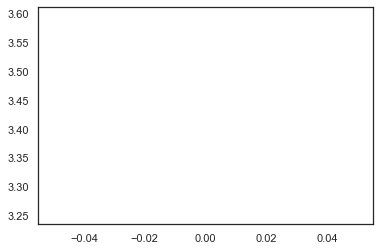

In [128]:
import matplotlib

#from matplotlib.colors import ListedColormap, LinearSegmentedColormap


cmap = matplotlib.cm.get_cmap('Blues')
colors = cmap(range(8))
colors
plt.plot(np.random.uniform(10),c=colors[1])

In [118]:
colors[0]

array([0.96862745, 0.98431373, 1.        , 1.        ])

In [10]:
def make_heatmap(median_fluorescence,Family,ax=None, **kwargs):
    """
    This is a function to generate heatmaps
    
    Args:
        median_fluorescence (pd.DataFrame)
        DataFrame of filtered single family Lux/Las/Tra flow cytometry median fluorescence intensity (mfi)
        
        standard_deviation (pd.DataFrame)
        DataFrame of filtered single family Lux/Las/Tra flow cytometry standard deviation of fluorescence intensity (mfi)
        
        ax (plt.ax)
        Axis to plot data on
        
        **kwargs
        Addition arguments to pass to sns.heatmap
    """
    sns.set_context('paper')
    ax = ax or plt.gca()
    mfi = median_fluorescence[median_fluorescence.Family ==Family]
    # normalized
    norm = mfi[mfi.logAHL != 0].copy()
    norm['FITC-A']=norm['FITC-A']/norm['FITC-A'].max()*100

    piv = norm.pivot_table(index='IPTG', columns='logAHL', values='FITC-A')
    g = sns.heatmap(piv, vmin=0,ax=ax,**kwargs)
    cbar = g.collections[0].colorbar
    cbar.set_ticks([0, 25, 50, 75,100])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    cbar.ax.set_ylabel('Relative Expression Level')
    ax.set_xlabel(r'AHL ($10^x$ M)')
    ax.set_ylabel(r'IPTG ($\mu M$)')
    #f.tight_layout()
    return ax

In [11]:
def get_hill_params(median_fluorescence,Family):
    """
    This is a function to generate Hill plots
    
    Args:
        median_fluorescence (pd.DataFrame)
            DataFrame of filtered single family Lux/Las/Tra flow cytometry median fluorescence intensity (mfi)
        Family (str)
            Name of AHL family to fit

    """
    mfi = median_fluorescence[median_fluorescence.Family ==Family]
    fits = pd.DataFrame(columns=['Slope','EC50','IPTG'])
    #data = Data[Data.Family =='LuxR']
    #cmap = matplotlib.cm.get_cmap(colormap)
    #colors = cmap(np.linspace(0,1,len(IPTG_range)+1))
    for replicate in mfi.Replicate.unique():
        for iptg in mfi.IPTG.unique():
            median = mfi[(mfi.IPTG==iptg) & (mfi.Replicate == replicate)]
            max_ = median['FITC-A'].max()
            min_ = median['FITC-A'].min()
            median = mfi[(mfi.IPTG==iptg) & (mfi.Replicate == replicate) & (mfi.logAHL != 0)]
            #print(replicate,iptg)
            def func(x, a, b):
                return (max_  - min_) / (1 + 10**(a * (np.log10(b)-np.log10(x)))) + min_
            (a_, b_), _ = opt.curve_fit(func, median.AHL, median['FITC-A'],p0=[1,1e-9],maxfev=10000000)
            fits=fits.append(pd.DataFrame([[a_,b_,iptg]],columns=['Slope','EC50','IPTG']),ignore_index=True)

    return fits

In [12]:
def plot_hill(median_fluorescence,standard_deviation,IPTG_range,Family,colormap,ax=None,  **kwargs):
    """
    This is a function to generate Hill plots
    
    Args:
        median_fluorescence (pd.DataFrame)
        DataFrame of filtered single family Lux/Las/Tra flow cytometry median fluorescence intensity (mfi)
        
        standard_deviation (pd.DataFrame)
        DataFrame of filtered single family Lux/Las/Tra flow cytometry standard deviation of fluorescence intensity (mfi)
        
        IPTG_range (list)
        List of IPTG values to plot
        
        colormap (str)
        Name of colormap to use
        
        ax (plt.ax)
        Axis to plot data on
        
        **kwargs
        Addition arguments to pass to sns.heatmap
    """
    sns.set_context('talk')
    ax = ax or plt.gca()
    lines = []  
    fits = pd.DataFrame(columns=['AHL','FITC-A','IPTG'])
    cmap = matplotlib.cm.get_cmap(colormap)
    colors = cmap(np.linspace(0,1,len(IPTG_range)+1))
    mfi = median_fluorescence[median_fluorescence.Family ==Family]
    mean = mfi.groupby(['IPTG','logAHL']).mean().reset_index()[['IPTG','logAHL','AHL','FITC-A']]
    std = mfi.groupby(['IPTG','logAHL']).std().reset_index()[['IPTG','logAHL','AHL','FITC-A']]
    for i,iptg in enumerate(IPTG_range):
        mn = mean[(mean.IPTG==iptg) & (mean.logAHL != 0)]
        sd = std[(std.IPTG==iptg) & (std.logAHL != 0)]
        ax.errorbar(x=mn.logAHL.values,y=mn['FITC-A'].values,yerr=sd['FITC-A'].values,color=colors[i],capsize=5,ls='',marker='o')
        def func(x, a, b):
            return (mn['FITC-A'].max() -mn['FITC-A'].min()) / (1 + 10**(a * (np.log10(b)-np.log10(x)))) + mn['FITC-A'].min()
        (a_, b_), _ = opt.curve_fit(func, mn.AHL, mn['FITC-A'],p0=[1,1e-9],maxfev=10000000)
        n = 1e6
        x = np.linspace(mn.AHL.min(), mn.AHL.max(), int(n))
        y_fit = func(x, a_, b_)
        fits=fits.append(pd.DataFrame(np.concatenate([[x], [y_fit],[np.ones(len(x))*iptg]]).T,columns=['AHL','FITC-A','IPTG']),ignore_index=True)
        lines2, =ax.plot(np.log10(x), y_fit, '-',color = colors[i],label='IPTG {:.1f} fit'.format(iptg))
        lines += ax.plot(mn.logAHL.values, mn['FITC-A'].values, 'o',color = colors[i],label=r'IPTG {} $\mu M$'.format(iptg))

    labels = [l.get_label() for l in lines]
    #labels = ax.get_labels()
    ax.legend(handles=lines,labels=labels,frameon=False)
    ax.set_xlabel(r'AHL ($10^x$ M)')
    ax.set_ylabel(r'mNG Intensity (au)')
    sns.despine()
    return ax

In [89]:
def plot_hill_params(mfi,Family,colormap,grid,**kwargs):

    gs1 = grid.subgridspec(3, 1)
    axes=gs1.subplots()
    median_fluorescence = mfi[mfi.Family==Family]
    fit = get_hill_params(median_fluorescence,Family)
    #gs01 = grid.subgridspec(3, 1)
    #inner_grid = gridspec.GridSpecFromSubplotSpec(
    #  3, 1, subplot_spec=grid)
    #ax1 = figure.add_subplot(inner_grid[0,:])
   # ax2 = figure.add_subplot(inner_grid[1,:])
    #ax3 = figure.add_subplot(inner_grid[2,:])
    sns.barplot(x='IPTG',y='R',data=median_fluorescence,palette=colormap,ax=axes[0])

    axes[0].set_ylabel(r'Induction ratio ($\frac{mNG_{ON}}{mNG_{OFF}}$)')
    sns.barplot(x='IPTG',y='EC50',data=fit,ax=axes[1],ci='sd',palette=colormap)
    axes[1].set_yscale('log')
    axes[1].set_ylabel(r'$EC_{50}$')
    sns.barplot(x='IPTG',y='Slope',data=fit,ax=axes[2],ci='sd',palette=colormap)
    axes[0].set_xlabel('')
    axes[1].set_xlabel('')
    axes[2].set_xlabel(r'IPTG ($\mu M$)')
    f.align_ylabels()
    f.tight_layout()
    sns.despine()
    return 

In [88]:
mfi

,IPTG,Family,logAHL,Replicate,FITC-A,AHL,R
0,0,LasR,-14,1,276.319992,1.000000e-14,11.280575
1,0,LasR,-14,2,242.879990,1.000000e-14,13.020242
2,0,LasR,-14,3,361.680008,1.000000e-14,12.901587
3,0,LasR,-13,1,305.360001,1.000000e-13,11.280575
4,0,LasR,-13,2,268.400009,1.000000e-13,13.020242
...,...,...,...,...,...,...,...
427,500,TraR,-4,2,250.800003,1.000000e-04,1.666667
428,500,TraR,-4,3,231.439987,1.000000e-04,1.738451
429,500,TraR,0,1,121.440002,0.000000e+00,1.731884
430,500,TraR,0,2,150.479996,0.000000e+00,1.666667


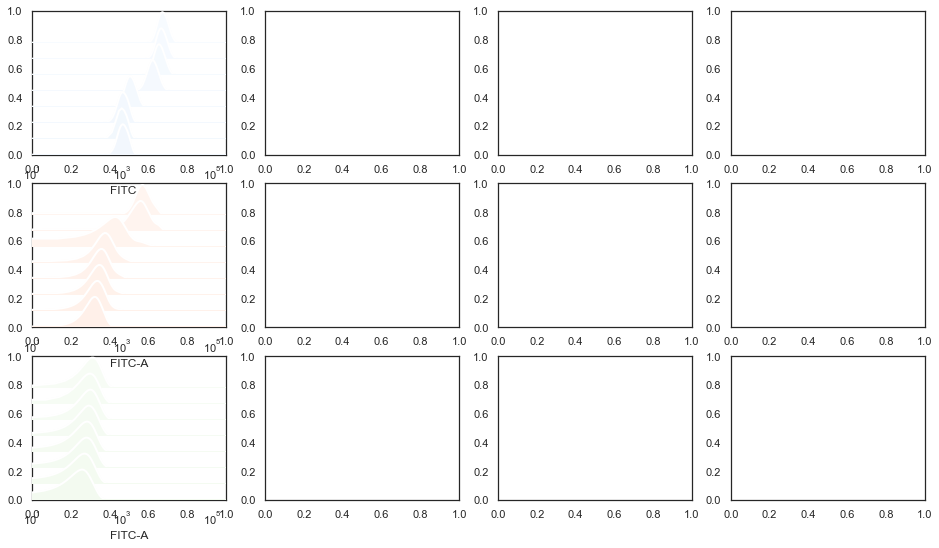

In [132]:
fig = plt.figure(figsize=(16,9))
gs = gridspec.GridSpec(3, 4, figure=fig)
axs1 = gs.subplots()
iptg = 5

def ridge_plot(Data,family,iptg,colormap,grid):
    sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    temp = Data[(Data.Family==family) & (Data.IPTG ==iptg)]
    gs1 = grid.subgridspec(len(temp.AHL.unique()), 1,hspace=-.5)
    axes=gs1.subplots()
    cmap = matplotlib.cm.get_cmap(colormap)
    colors = cmap(range(len(temp.AHL.unique())))
    for color,c,ax in zip(colors,temp.AHL.unique(),axes.ravel()):
        temp2 = temp[temp.AHL == c]
        sns.kdeplot(temp[temp.AHL == c]['FITC-A'],clip_on=True, fill=True, alpha=1, lw=1,bw_adjust=3,ax=ax,color=color) #log_scale=True,
        sns.kdeplot(temp[temp.AHL == c]['FITC-A'],clip_on=True, color='w', alpha=1, lw=2,bw_adjust=3,ax=ax)
        ax.axhline(y=0, lw=2,c=color)
    spines = ["top","right","left","bottom"]
    for j,ax in enumerate(axes.ravel(),1):
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.set_xlim(1e1,2e5)
        ax.set_xscale('log')
        for s in spines:
            ax.spines[s].set_visible(False)
        if j == len(temp.AHL.unique()):
            ax.set_xlabel('FITC-A')
            
        else:
            ax.set_xticklabels([])
            ax.set_xlabel('')


ridge_plot(Data,'LuxR',5,'Blues',grid=gs[0,0])
ridge_plot(Data,'LasR',5,'Reds',grid=gs[1,0])
ridge_plot(Data,'TraR',5,'Greens',grid=gs[2,0])

In [133]:
fig = plt.figure(constrained_layout=True, figsize=(15,9))
gs0 = gridspec.GridSpec(3, 4, figure=fig)
sns.set_context('paper')
sns.set_style('white')
spines = ["top","right","left","bottom"]
# Initialize plot axes
# ridge plots
ax1 = fig.add_subplot(gs0[0, 0])
ax2 = fig.add_subplot(gs0[1, 0])
ax3 = fig.add_subplot(gs0[2, 0])

# Hill plots
ax4 = fig.add_subplot(gs0[0, 1])
ax5 = fig.add_subplot(gs0[1, 1])
ax6 = fig.add_subplot(gs0[2, 1])

# Heatmaps
ax7 = fig.add_subplot(gs0[0, 2])
ax8 = fig.add_subplot(gs0[1, 2])
ax9 = fig.add_subplot(gs0[2, 2])

# Hill Params
#ax10 = fig.add_subplot(gs0[0, 3])
#ax11 = fig.add_subplot(gs0[1, 3])
#ax12 = fig.add_subplot(gs0[2, 3])



plot_hill(mfi,std,[0,5,500],'LuxR','Blues_r',ax4)
plot_hill(mfi,std,[0,5,500],'LasR','Reds_r',ax5)
plot_hill(mfi,std,[0,5,500],'TraR','Greens_r',ax6)

make_heatmap(mfi,'LuxR',ax7,cmap='Blues_r')
make_heatmap(mfi,'LasR',ax8,cmap= 'Reds_r')
make_heatmap(mfi,'TraR',ax9,cmap='Greens_r')

plot_hill_params(mfi,'LuxR',colormap='Blues_r',grid=gs0[0, 3])
plot_hill_params(mfi,'LasR',colormap='Reds_r',grid=gs0[1, 3])
plot_hill_params(mfi,'TraR',colormap='Greens_r',grid=gs0[2, 3])

ridge_plot(Data,'LuxR',5,'Blues',grid=gs[0,0])
ridge_plot(Data,'LasR',5,'Reds',grid=gs[1,0])
ridge_plot(Data,'TraR',5,'Greens',grid=gs[2,0])

for ax in [ax1,ax2,ax3]:
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    for s in spines:
        ax.spines[s].set_visible(False)


<ipython-input-12-cbed587a2eec>:38: RuntimeWarning: invalid value encountered in log10
  return (mn['FITC-A'].max() -mn['FITC-A'].min()) / (1 + 10**(a * (np.log10(b)-np.log10(x)))) + mn['FITC-A'].min()
<ipython-input-12-cbed587a2eec>:38: RuntimeWarning: invalid value encountered in log10
  return (mn['FITC-A'].max() -mn['FITC-A'].min()) / (1 + 10**(a * (np.log10(b)-np.log10(x)))) + mn['FITC-A'].min()
<ipython-input-11-ddf703cbb948>:25: RuntimeWarning: invalid value encountered in log10
  return (max_  - min_) / (1 + 10**(a * (np.log10(b)-np.log10(x)))) + min_
<ipython-input-11-ddf703cbb948>:25: RuntimeWarning: invalid value encountered in log10
  return (max_  - min_) / (1 + 10**(a * (np.log10(b)-np.log10(x)))) + min_
<ipython-input-11-ddf703cbb948>:25: RuntimeWarning: invalid value encountered in log10
  return (max_  - min_) / (1 + 10**(a * (np.log10(b)-np.log10(x)))) + min_
<ipython-input-11-ddf703cbb948>:25: RuntimeWarning: invalid value encountered in log10
  return (max_  - min_)

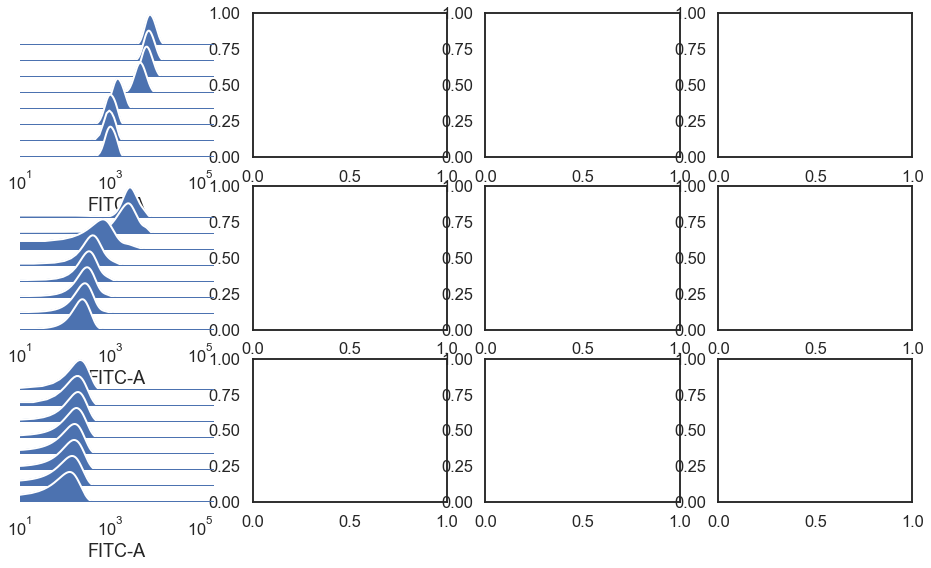

In [83]:
fig = plt.figure(figsize=(16,9))
gs = gridspec.GridSpec(3, 4, figure=fig)
axs1 = gs.subplots()
iptg = 5

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
        #ax.set_xlim(1e2,2e5)
    ax.set(xlim=(1e1,1e5))
    #g.map(label, "FITC-A")
def ridge(Data,family,iptg,cmap,axes):
        temp = Data[(Data.Family==family) & (Data.IPTG ==iptg)]
        for c,ax in zip(temp.AHL.unique(),axes.ravel()):
            temp2 = temp[temp.AHL == c]
            sns.kdeplot(temp[temp.AHL == c]['FITC-A'],clip_on=True, shade=True, alpha=1, lw=1,bw_adjust=3,ax=ax,palette='Greens') #log_scale=True,
            sns.kdeplot(temp[temp.AHL == c]['FITC-A'],clip_on=True, color='w', alpha=1, lw=2,bw_adjust=3,ax=ax)
            ax.axhline(y=0, lw=2)
spines = ["top","right","left","bottom"]
families = ['LuxR','LasR','TraR']
cmaps = ['Blues','Reds','Greens']
grids = list()
axes = list()
for i,family in enumerate(families):
    ahls = Data[(Data.Family==family) & (Data.IPTG ==iptg)].AHL.unique()
    grids.append(gs[i,0].subgridspec(len(ahls), 1,hspace=-.5))
    axes.append(gs[i,0].subgridspec(len(ahls), 1,hspace=-.5).subplots())

for i, (family,axs) in enumerate(zip(families,axes)):
    ahls = Data[(Data.Family==family) & (Data.IPTG ==iptg)].AHL.unique()
    axs

    ridge(Data,family,iptg,cmaps[i],axs)

    for j,ax in enumerate(axs.ravel(),1):
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.set_xlim(1e1,2e5)
        ax.set_xscale('log')
        for s in spines:
            ax.spines[s].set_visible(False)
        if j == len(ahls):
            ax.set_xlabel('FITC-A')
            
        else:
            ax.set_xticklabels([])
            ax.set_xlabel('')
    for ax in axs1[:,0]:
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for s in spines:
            ax.spines[s].set_visible(False)
    # Set the subplots to overlap
#fig.subplots_adjust(hspace=-.5)

# Remove axes details that don't play well with overlap
#g.set_titles("")
#g.set(yticks=[])


<AxesSubplot:xlabel='FITC-A', ylabel='Density'>

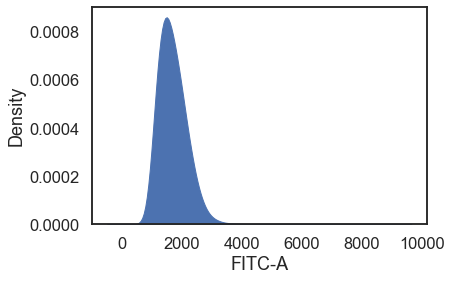

In [84]:
sns.kdeplot(Data[(Data.Family=='LuxR') & (Data.IPTG ==5) & (Data.AHL == 1e-8)]['FITC-A'],clip_on=True, shade=True, alpha=1, lw=1,bw_adjust=3,palette='Greens')

C:\Users\sakkosjo\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\sakkosjo\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\sakkosjo\Anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\sakkosjo\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\sakkosjo\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\sakkosjo\Anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 v

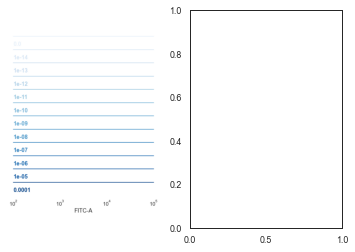

In [19]:
def ridgeplot(data,iptg,colormap,ax=None):
    ax = ax or plt.gca()
    sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    sns.set_context('talk')
    tmpdf = Data[Data.IPTG==iptg][['AHL','FITC-A']]
    #print('IPTG=' +str(I))
    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(tmpdf, row="AHL", hue="AHL", aspect=10, height=.75, palette=colormap)#
    #g.set(xlim=(0, 20000))
    # Draw the densities in a few steps
    g.map(sns.kdeplot, "FITC-A", clip_on=True, shade=True, alpha=1, lw=1,log_scale=True,bw_adjust=3)
    g.map(sns.kdeplot, "FITC-A", clip_on=True, color="w", lw=2,log_scale=True,bw_adjust=3)
    g.map())


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
        #ax.set_xlim(1e2,2e5)
    g.set(xlim=(1e2,1e5))
    g.map(label, "FITC-A")
    #if I ==0.001:
    #    g.map(label, "FITC-A")
    #else:
     #   g.map(label, "FITC-A")
     #   for ax in g.axes.flat:
     #       ax.set_axis_off()
      #  g.set(xticks=[])

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.5)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    g.savefig('ridge.png')
    plt.close(g.fig)
    
    return ax.imshow(mpimg.imread('ridge.png'))
f, axes = plt.subplots(ncols=2)
ridgeplot(data=Data[Data.Family=='LuxR'],iptg=5,colormap='Blues',ax=axes[0])
axes[0].set_axis_off()

C:\Users\sakkosjo\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\sakkosjo\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\sakkosjo\Anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\sakkosjo\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\sakkosjo\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\sakkosjo\Anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 v

ValueError: <AxesSubplot:> is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

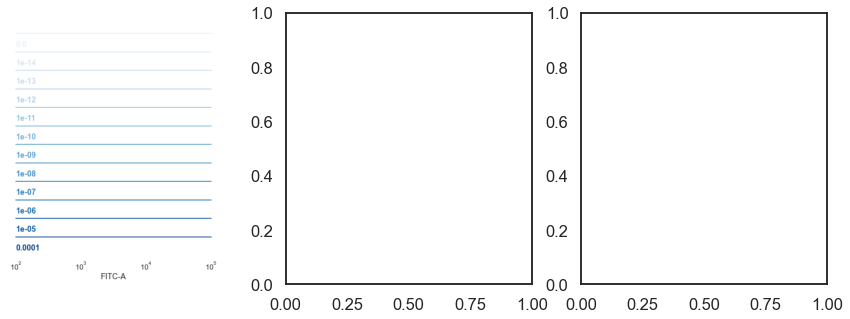

In [20]:
f, axes = plt.subplots(ncols=3,figsize=(15,5))
ridgeplot(data=Data[Data.Family=='LuxR'],iptg=5,colormap='Blues',ax=axes[0])
axes[0].set_axis_off()
plot_hill(mfi,std,[0,5,10,500],'YlGnBu',axes[1])
make_heatmap(lx,axes[2],cmap='YlGnBu')
f.tight_layout()

In [ ]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
sns.set_context('talk')
for I in data.IPTG.unique():
    tmpdf = data[data.IPTG==I][['AHL','FITC-A']]
    print('IPTG=' +str(I))
    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(tmpdf, row="AHL", hue="AHL", aspect=10, height=.75, palette='Reds')#
    #g.set(xlim=(0, 20000))
    # Draw the densities in a few steps
    g.map(sns.kdeplot, "FITC-A", clip_on=True, shade=True, alpha=1, lw=1,log_scale=True,bw_adjust=3)
    g.map(sns.kdeplot, "FITC-A", clip_on=True, color="w", lw=2,log_scale=True,bw_adjust=3)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
        #ax.set_xlim(1e2,2e5)
    g.set(xlim=(1e3,1e5))

    if I ==0.001:
        g.map(label, "FITC-A")
    else:
        g.map(label, "FITC-A")
        for ax in g.axes.flat:
            ax.set_axis_off()
        g.set(xticks=[])

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.5)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)
    #plt.show()
    #g.savefig('Ridge_Las_IPTG {:.1e}.pdf'.format(I))
